In [1]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
from typing import List
import numpy as np
from copy import deepcopy
import joblib
from pprint import pprint
from math import ceil
import cortex
from neuro import config
from collections import defaultdict
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests
import gct
from neuro.flatmaps_helper import load_flatmaps
import neuro.sasc.viz
from neuro import analyze_helper
import neuro.viz
import nibabel as nib
neurosynth_compare = __import__('04_neurosynth_compare')
import neurosynth
from neuro.features.questions.gpt4 import QS_35_STABLE, QUESTIONS_GPT4_COMPUTED_FULL
from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import viz
config.setup_freesurfer()

subject = 'S02'
subjects = [f'S0{i}' for i in range(1, 9) if not i == 6] # there's some problem with S06 surf2surf
# subjects = ['S01', 'S02', 'S03']

/home/chansingh/.venv/lib/python3.12/site-packages/cortex/mni.py:21: UserWarning: Can't find FSLDIR environment variable, assuming default FSL location..
  warnings.warn("Can't find FSLDIR environment variable, assuming default FSL location..")


### single flatmap neurosynth

In [ ]:
subj_vols = []
for term in ['place', 'location']:  # , 'locations']:
    mni_filename = join(config.NEUROSYNTH_DATA_DIR,
                        f'all_association-test_z/{term}_association-test_z.nii.gz')
    mni_vol = cortex.Volume(mni_filename, "fsaverage", "atlas_2mm")
    subj_vol, subj_arr = neurosynth.mni_vol_to_subj_vol_surf(
        mni_vol, subject=subject)
    print('mni shape', mni_vol.shape, 'subj shape',
          subj_vol.shape, 'subj_arr shape', subj_arr.shape)

    neuro.sasc.viz.quickshow(
        subj_vol.data,
        subject='UT' + subject,
        fname_save=join(f'intersubject/{term}_subj.png'),
        with_colorbar=False,
    )
    neuro.sasc.viz.quickshow(
        mni_vol,
        subject='fsaverage',
        fname_save=join(f'intersubject/{term}_mni.png'),
        with_colorbar=False,
    )
    subj_vols.append(subj_vol.data)

neuro.sasc.viz.quickshow(
    np.array(subj_vols).mean(axis=0),
    subject='UT' + subject,
    fname_save=join(f'intersubject/avg_subj.png'),
    with_colorbar=False,
)

### each individual subject (shows inter-subject)

In [ ]:
# qs = ['Does the sentence mention a specific location?']
for q in tqdm(QS_35_STABLE):
    for subject in ['S01', 'S02', 'S03']:  # ['S01', 'S02', 'S03']:
        # if subject in ['S03']:
        # settings = ['individual_gpt4', 'individual_gpt4_wordrate', 'shapley_35']
        # settings = ['shapley_35']
        # else:
        settings = ['individual_gpt4_pc_new']
        flatmaps_qa_list = defaultdict(list)
        for setting in settings:
            flatmaps_qa_dict = joblib.load(
                join(config.PROCESSED_DIR, subject.replace('UT', ''), setting + '.pkl'))
            flatmaps_qa_list[q].append(flatmaps_qa_dict[q])
        flatmaps_qa_dict = {
            q: np.mean(flatmaps_qa_list[q], axis=0)
            for q in flatmaps_qa_list.keys()}

        print('visualizing...')
        neuro.viz.quickshow(
            flatmaps_qa_dict[q],
            subject='UT'+subject,
            fname_save=join('save_flatmaps', subject, q + '.pdf'),
            with_colorbar=False,
            # cmap='RdYlBu_r',
        )

In [ ]:
# save a RedBlue horizontal colorbar
def save_colorbar(cmap, norm, orientation='horizontal', filename='colorbar.png'):
    if orientation == 'vertical':
        fig, ax = plt.subplots(figsize=(0.5, 2.5))
        fig.subplots_adjust(left=0.5)
    else:
        fig, ax = plt.subplots(figsize=(2.5, 0.5))
        fig.subplots_adjust(bottom=0.5)
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
                        cax=ax, orientation=orientation)
    cbar.set_label('Normalized weight')
    plt.savefig(filename, bbox_inches='tight', dpi=300, transparent=True)
    plt.close(fig)


cmap = cm.RdBu_r
norm = Normalize(vmin=-1, vmax=1)
save_colorbar(cmap, norm, orientation='horizontal',
              filename='colorbar_norm.png')
save_colorbar(cmap, norm, orientation='vertical',
              filename='colorbar_norm_vert.png')

In [ ]:
# save flatmaps into a grid
for subject in ['S01', 'S02', 'S03']:
    C = 4
    R = 9
    fig, axs = plt.subplots(R, C, figsize=(12 * 1.7 * 4/5, 12*9/7))
    for i, q in enumerate(QS_35_STABLE):
        img = mpimg.imread(
            join('save_flatmaps', subject, q + '.png'))
        axs[i//C, i % C].imshow(img)
        # axs[i//C, i % C].axis('off')
        axs[i//C, i % C].set_title(analyze_helper.abbrev_question(q))
    for i in range(R * C):
        axs[i//C, i % C].axis('off')
    plt.tight_layout()
    plt.savefig(join(
        'save_flatmaps', subject + '_grid.pdf'))

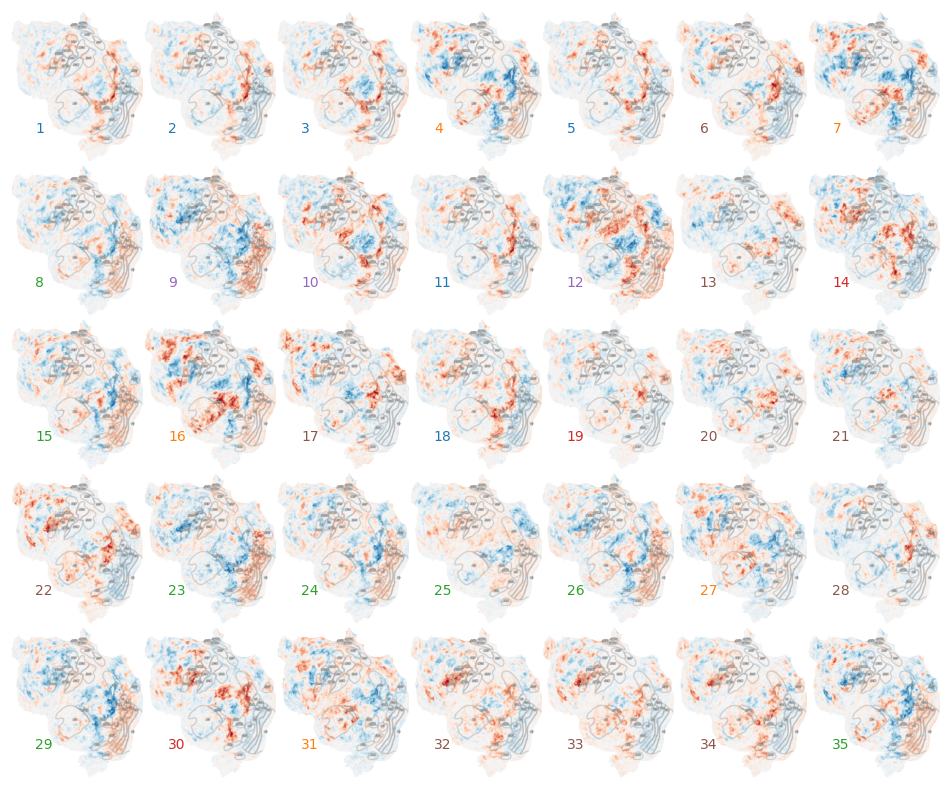

In [ ]:
# save single-hemisphere into a grid
survey_df = pd.read_pickle('monosemantic/single_question_perf_and_survey.pkl').sort_values(by='Average', ascending=False)
question_order = survey_df['question_abbrev']
QUESTION_ORDER = list(question_order[question_order.isin([analyze_helper.abbrev_question(q) for q in QS_35_STABLE])].values)

tab10 = plt.get_cmap('tab10')
q_to_idx = {analyze_helper.abbrev_question(q): i for (q,i) in viz.REMAP_QUESTIONS_TO_CATEGORY_IDXS.items()}
n_colors = len(set(q_to_idx.values()))
colors = [tab10(i) for i in range(n_colors)]


for subject in ['S02']: #['S01', 'S02', 'S03']:
    C = 7
    R = 5
    # remove space between subplots
    fig, axs = plt.subplots(R, C, figsize=(12, 10), gridspec_kw={'hspace': 0, 'wspace': 0})
    for q in QS_35_STABLE:

        i = QUESTION_ORDER.index(analyze_helper.abbrev_question(q))

        img = mpimg.imread(
            join('save_flatmaps', subject, q + '.png'))

        # trim 45% of image
        img = img[:, :int(img.shape[1] * 0.475), :]


        axs[i//C, i % C].imshow(img)
        # axs[i//C, i % C].axis('off')
        # axs[i//C, i % C].set_title(analyze_helper.abbrev_question(q))

        # add text in bottom left corner with color blue
        axs[i//C, i % C].text(0.19, 0.2, str(i + 1),
                              transform=axs[i//C, i % C].transAxes,
                              color=colors[q_to_idx[analyze_helper.abbrev_question(q)]])

    for i in range(R * C):
        axs[i//C, i % C].axis('off')
    # plt.tight_layout()

    # save with no extra spacing
    plt.savefig(join(
        'save_flatmaps', subject + '_half_grid.pdf'), bbox_inches='tight', dpi=300, transparent=True)
    plt.savefig(join(
        'save_flatmaps', subject + '_half_grid.png'), bbox_inches='tight', dpi=300, transparent=True)


### gct flatmaps

In [ ]:
gemv_flatmaps_dict_S02, gemv_flatmaps_dict_S03 = load_flatmaps(
    normalize_flatmaps=False, load_timecourse=False)
q_tup = ('locations', 368)
neuro.sasc.viz.quickshow(
    gemv_flatmaps_dict_S02[q_tup],
    subject='UTS02',
    fname_save=join('save_flatmaps', q_tup[0], f'gemv_S02.png'),
    with_colorbar=False,
    # cmap='RdYlBu_r',
)